# 任务3：LSTM网络实现RNN写作生成

**任务要求：利用LSTM网络实现RNN的莎士比亚风格文本写作生成。**  
**数据: shakespeare.txt**

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import unidecode
import string
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
use_gpu = True if torch.cuda.is_available() else False
print('Use GPU:', use_gpu)

Use GPU: False


## 1. 加载文本数据

加载训练文本数据及字符集

In [5]:
all_characters = string.printable
n_characters = len(all_characters)
print('characters num:', n_characters)
print(all_characters)

file = unidecode.unidecode(open('./data/shakespeare.txt').read())
file_len = len(file)
print('file length:', file_len)

characters num: 100
0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

file length: 1115394


### 随机文本块

In [6]:
chunk_len = 500

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index: end_index]

print(random_chunk())

;
go on the right hand: I will but look upon the
hedge and follow you.

Clown:
We are blest in this man, as I may say, even blest.

Shepherd:
Let's before as he bids us: he was provided to do us good.

AUTOLYCUS:
If I had a mind to be honest, I see Fortune would
not suffer me: she drops booties in my mouth. I am
courted now with a double occasion, gold and a means
to do the prince my master good; which who knows how
that may turn back to my advancement? I will bring
these two moles, these blind o


### 随机数据-标签对

In [7]:
def char_tensor(string):
    n = len(string)
    t = torch.zeros(n).long()
    for i in range(n):
        t[i] = all_characters.index(string[i])
    return Variable(t)

print(char_tensor('(abcdef,ABCDEF).'))

tensor([69, 10, 11, 12, 13, 14, 15, 73, 36, 37, 38, 39, 40, 41, 70, 75])


In [8]:
def random_training_set():
    chunk = random_chunk()
    inputs = char_tensor(chunk[:-1])
    targets = char_tensor(chunk[1:])
    return inputs, targets

random_training_set()

(tensor([94, 17, 18, 28, 94, 18, 28, 21, 10, 23, 13, 94, 16, 18, 27, 29, 94, 18,
         23, 94, 32, 18, 29, 17, 94, 29, 17, 14, 94, 24, 12, 14, 10, 23, 73, 96,
         50, 27, 94, 22, 24, 13, 14, 28, 29, 94, 39, 18, 10, 23, 94, 12, 18, 27,
         12, 21, 14, 13, 94, 32, 18, 29, 17, 94, 17, 14, 27, 94, 23, 34, 22, 25,
         17, 28, 73, 96, 54, 17, 10, 21, 21, 94, 27, 14, 28, 29, 94, 18, 23, 94,
         47, 24, 23, 13, 24, 23, 94, 29, 18, 21, 21, 94, 32, 14, 94, 12, 24, 22,
         14, 94, 29, 24, 94, 17, 18, 22, 75, 96, 41, 10, 18, 27, 94, 21, 24, 27,
         13, 28, 73, 94, 29, 10, 20, 14, 94, 21, 14, 10, 31, 14, 94, 10, 23, 13,
         94, 28, 29, 10, 23, 13, 94, 23, 24, 29, 94, 29, 24, 94, 27, 14, 25, 21,
         34, 75, 96, 41, 10, 27, 14, 32, 14, 21, 21, 73, 94, 22, 34, 94, 28, 24,
         31, 14, 27, 14, 18, 16, 23, 75, 96, 96, 46, 44, 49, 42, 94, 43, 40, 49,
         53, 60, 94, 57, 44, 77, 96, 41, 10, 27, 14, 32, 14, 21, 21, 73, 94, 22,
         34, 94, 43, 14, 12,

## 2. RNN模型

利用PyTorch构建RNN模型类，内部包括Embedding层、LSTM、FC层

In [9]:
''' 请在下方编写RNN模型类 '''
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, inputs, hidden):
        inputs = self.encoder(inputs.view(1, -1))
        outputs, hidden = self.lstm(inputs.view(1, 1, -1), hidden)
        outputs = self.decoder(outputs.view(1, -1))
        return outputs, hidden
    
    def init_hidden(self):
        h0 = Variable(torch.zeros(self.num_layers, 1, self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers, 1, self.hidden_size))
        return h0, c0

## 3. 训练函数

In [10]:
def train(inputs, target):
    h, c = rnn.init_hidden()
    if use_gpu:
        inputs = inputs.cuda()
        target = target.cuda()
        h, c = h.cuda(), c.cuda()
    hidden = h, c
    
    loss = 0
    for i in range(len(inputs)):
        ''' 请在下方编写rnn模型输出，及loss累加代码'''
        outputs, hidden = rnn(inputs[i], hidden)
        loss += criterion(outputs, target[i].view([1]))
    
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.data.item()/len(inputs)

## 4. 文本生成测试函数

In [11]:
def test(prime_str='A', predict_len=100, temperature=0.8):
    h, c = rnn.init_hidden()
    prime_input = char_tensor(prime_str)
    if use_gpu:
        h, c = h.cuda(), c.cuda()
        prime_input = prime_input.cuda()
    predicted = prime_str
    
    for i in range(len(prime_str)-1):
        _, (h, c) = rnn(prime_input[i], (h, c))
    inputs = prime_input[-1]

    for p in range(predict_len):
        if use_gpu:
            inputs = inputs.cuda()
        output, (h, c) = rnn(inputs, (h, c))
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inputs = char_tensor(predicted_char)
    
    return predicted

## 5. 模型训练

#### 超参数

In [12]:
''' 请自行设定相关参数 '''
epoch_num = 1000  # 1000~10000
print_every = 100
plot_every = 10
hidden_size = 100
num_layers = 1
lr = 0.01

#### 模型、优化器、损失函数

In [13]:
# RNN模型
rnn = RNN(n_characters, hidden_size, n_characters, num_layers)
if use_gpu:
    rnn = rnn.cuda()
print(rnn)

RNN(
  (encoder): Embedding(100, 100)
  (lstm): LSTM(100, 100)
  (decoder): Linear(in_features=100, out_features=100, bias=True)
)


In [14]:
# 优化器
''' 请在下方编写Adam优化器定义的代码 '''
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
print(optimizer)

# 损失函数
''' 请在下方编写交叉熵损失函数定义的代码 '''
criterion = nn.CrossEntropyLoss()
print(criterion)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
CrossEntropyLoss()


#### 模型训练

In [15]:
time_start = time.time()
evaluate = True  # 可设置为False，训练过程中不评估
loss_list = []
loss_avg = 0

for epoch in range(1, epoch_num+1):
    inputs, targets = random_training_set()
    loss = train(inputs, targets)
    loss_avg += loss
    
    if epoch % print_every == 0:
        print('[Time: %ds  Epoch: %d (%d%%)  Loss: %.4f]'%(int(time.time()-time_start), epoch, epoch/epoch_num*100, loss))
        if evaluate:
            pred_text = test('Th', 200)
            print(pred_text, '\n')
        
    if epoch % plot_every == 0:
        loss_list.append(loss_avg/plot_every)
        loss_avg = 0

[Time: 111s  Epoch: 100 (10%)  Loss: 2.1003]
Thating fall thate nam shatr daif smeve
or and,
Feaded no doued and and mess furise and I four me bake the such of not nensperd rean,' fak'.

PEINI Bett bangt hars my me weris the death blet if that, an 

[Time: 221s  Epoch: 200 (20%)  Loss: 2.0574]
Thes with. poor thus sou with not thou thee not will with ast,
Thil then our's
This cacth wervating thou for this.

JUKE RINGBOLIUS:
Wiht now thy are unon on this the love this is wourd of coursent the  

[Time: 331s  Epoch: 300 (30%)  Loss: 1.9967]
Thee we liching's a my that that sut this the man in upon you to man then swell, then nevine and an for us, my a an thun ther taman?

CARIRY LAJINGUCARLA:
The an and you then Lome, Sear is a goonich the 

[Time: 441s  Epoch: 400 (40%)  Loss: 1.9017]
Thye the conde,
And a king, is musty bothare stet and you bood.

AUCHEPENTHARDY ARWCLINGRWHIES:
O thy ot now, feight hereean.

PIRIAAly hear whosre cord Mile,
Nouned your doth he moral!

FRICHARD VINGSR 



## 6. 训练Loss曲线

绘制训练过程中的Loss曲线

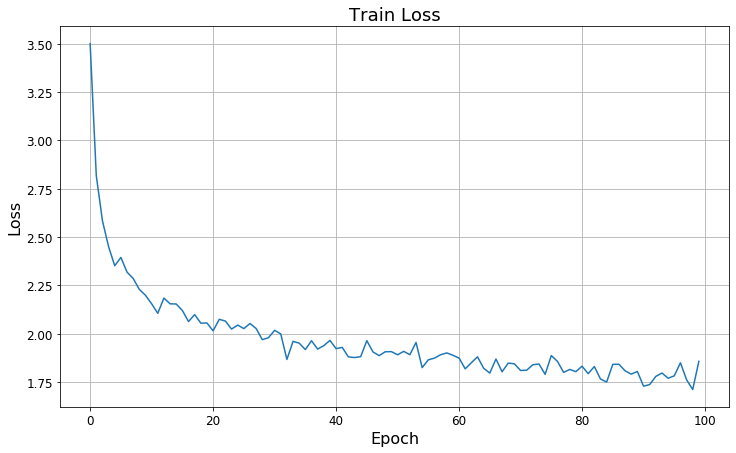

In [16]:
plt.figure(figsize=(12, 7))
plt.plot(loss_list)
plt.title('Train Loss', fontsize=18)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()

## 7. 测试

自定义初始字符和文本长度以生成文本

In [17]:
test_text = test('Th', 1000, 0.8)
print(test_text)

Tham folling Harsents, the crows in take this;
No shall to hange is hold upon is him must,
Not ear she joyering fight your thems.

CATIOND:
His shy being lare where it him shour forth
But Nurge now be the' thy abours.

SLY OF YORIZABELLA:
First therise to must sich my fair a prack
Is shall brauds now, whil, and be speak ofter earth with trusterdiaght,
What apperio, seave our took of ese him madiut frold may, my right the selds the prest abry poase wan the resely our care end am this sones oul we friends!

An Kings, is now:
Where says vire to be armorry,
And his now, too, mights sir, stirily from all brous our our him with to Clanty susting firgend,
Words, at will this good should heir sgrewh the pray of sidier,
And but a kerises with as tis not to book the beart.

SLOXDCAD:
Will retturrign, we'll him.

Sor Servind:
Were a provis.

HENROR CINIO:
A be the strage cold.

COMILLO:
Now we the vay! Acth's by be were clipusself
My plops subs plin were the bown
He shoughtion thy shour stors, wo

In [18]:
test_text = test('Wh', 1000, 0.8)
print(test_text)

Whould my must must it to fears!

KING EDWARD VI:
Stay, and for to's not say in the greatard
Say, forluning the crown, will his not mad, the sturs, let on is and brromout and must rersold bist house?
Doth, fore: and to my loves.

LADY VINV:
Wimbuse be shall my king a their will father.

ANTONS OLIO:
Rostss my sooursing for me the glam,
The'll which trustrends his fried my curve!

KING EDWARDIZABETI:
O, mer, thy parkay your not feariops
The four myself.

KATHARDIO:
Lood for shir, the words, as sumble fall well of whill wasture,
Sir for Riningmorious it,
Seir soppy lim?

DUKE ANNE:
Not since the pray, the was will more in so what,
The restingman will core.

Second born: with will pray.

RIANIUS:
Our, be and in erving thou aredods!

GLOUCHARE:
O so for of bear my to you taster withought elidge?
Prakes fir part my way, sidrame my please sonds,
Stand him tone sink his this sit and lantle for that the Marporest our fights.

Sechincingnesser, printering sold a seast.

KING EDWARD VINGBROKE:
N